# Data Loading

In [1]:
# data_loader.py

import pandas as pd
import requests
import streamlit as st
import unicodedata

@st.cache_data
def load_player_data_from_api():
    """Fetches player data from the FPL API and returns a DataFrame with selected columns."""
    try:
        response = requests.get("https://fantasy.premierleague.com/api/bootstrap-static/")
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        st.error(f"There was an error: {e} while retrieving data")
        return pd.DataFrame()  # Return empty DataFrame on error

    # Load data into DataFrames
    df_elements = pd.DataFrame(data["elements"])
    df_element_types = pd.DataFrame(data["element_types"])
    df_teams = pd.DataFrame(data["teams"])

    # Merge df_elements and df_element_types on 'element_type' and 'id'
    df_merged = df_elements.merge(
        df_element_types[['id', 'plural_name_short', 'plural_name']],
        left_on='element_type',
        right_on='id',
        how='left'
    )

    # Merge with teams to get team names
    df_merged = df_merged.merge(
        df_teams[['id', 'name']],
        left_on='team',
        right_on='id',
        how='left',
        suffixes=('', '_team')
    )

    # Rename columns
    df_merged.rename(columns={
        'plural_name_short': 'position',
        'name': 'team_name',
        'photo': 'photo',
        'code': 'code'
    }, inplace=True)

    # Drop redundant columns
    df_merged.drop(columns=['id_y', 'id'], inplace=True)
    df_merged.rename(columns={'id_x': 'id'}, inplace=True)

    # Standardize 'position' to upper case
    df_merged['position'] = df_merged['position'].str.upper()

    # Add 'player_value_score' (custom metric, here set equal to 'total_points')
    df_merged['player_value_score'] = df_merged['total_points']

    # Construct player photo URLs
    df_merged['photo_url'] = df_merged.apply(
        lambda row: f"https://resources.premierleague.com/premierleague/photos/players/110x140/p{row['code']}.png",
        axis=1
    )

    # Select the desired columns
    columns_to_use = [
        'id', 'web_name', 'first_name', 'second_name', 'position', 'plural_name', 'now_cost',
        'total_points', 'player_value_score', 'minutes', 'goals_scored',
        'assists', 'clean_sheets', 'goals_conceded', 'yellow_cards',
        'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
        'threat', 'ict_index', 'selected_by_percent', 'form', 'points_per_game',
        'team_name', 'in_dreamteam', 'dreamteam_count', 'photo_url', 'event_points'
    ]

    # Ensure all selected columns exist in the DataFrame
    df_final = df_merged[columns_to_use]
    
    # Remove accents from player_names
    def remove_accents(input_str):
        return ''.join(
            char for char in unicodedata.normalize('NFD', input_str)
            if unicodedata.category(char) != 'Mn'
        )

    # Apply the function to the 'web_name' column
    df_final['web_name_cleaned'] = df_final['web_name'].apply(remove_accents)
    df_final.loc[:, 'full_name'] = df_final['first_name'] + ' ' + df_final['second_name']
    return df_final

@st.cache_data()
def load_gameweek_data_from_github(year: str):
    """Fetches gameweek by gameweek player data from the Github Dataset and returns a DataFrame with selected columns."""
    
    try:
        url_gw = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{year}/gws/merged_gw.csv"
        df = pd.read_csv(url_gw)
    except Exception as e:
        st.error(f"There was an error: {e} while retrieving data")
        return pd.DataFrame()
    
    df["position"] = df["position"].apply(lambda x: 'GKP' if x == 'GK' else x)
    
    # Function to remove accents
    def remove_accents(input_str):
        return ''.join(
            char for char in unicodedata.normalize('NFD', input_str)
            if unicodedata.category(char) != 'Mn'
        )

    # Apply the function to the 'web_name' column
    df['name'] = df['name'].apply(remove_accents)
    # df.loc[:, 'full_name'] = df['first_name'] + ' ' + df['second_name']
    return df

2024-12-05 16:44:35.417 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-05 16:44:35.425 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## Ignore

In [2]:
df =load_player_data_from_api()

2024-12-05 16:44:36.542 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:37.154 
  command:

    streamlit run c:\Users\Jacob\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-12-05 16:44:37.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:37.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:37.160 No runtime found, using MemoryCacheStorageManager
C:\Users\Jacob\AppData\Local\Temp\ipykernel_18248\607633312.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [ ]:
def compare_two_players_full_name(df, player1_full_name, player2_full_name, title="Player Comparison"):

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Fixed stats to compare
    stats_to_compare = [
        'goals_scored',
        'assists', 'clean_sheets', 'form', 'points_per_game'
    ]

    # Ensure full name column is created with string types
    df['full_name'] = df['first_name'].astype(str) + ' ' + df['second_name'].astype(str)

    # Filter data for the two players
    players_df = df[df['full_name'].isin([player1_full_name, player2_full_name])]

    # Check if both players exist
    if players_df.shape[0] < 2:
        raise ValueError("Both players must exist in the dataset.")

    # Select relevant columns and enforce numeric data type
    players_df = players_df[['full_name'] + stats_to_compare]
    for stat in stats_to_compare:
        players_df[stat] = pd.to_numeric(players_df[stat], errors='coerce')  # Convert to numeric

    # Handle missing values (e.g., fill with 0 or drop rows with NaN)
    players_df.fillna(0, inplace=True)

    # Pivot the data for easy plotting
    players_stats = players_df.set_index('full_name')[stats_to_compare].T

    # Plot setup
    players = [player1_full_name, player2_full_name]
    x = np.arange(len(stats_to_compare))  # the label locations
    width = 0.35  # the width of the bars

    # Soccer-themed colors and styles
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_facecolor('#101820')  # Darker black for the chart background

    # Create bars for both players
    bars1 = ax.bar(x - width / 2, players_stats[players[0]].values, width, label=players[0], color='red', edgecolor='white')
    bars2 = ax.bar(x + width / 2, players_stats[players[1]].values, width, label=players[1], color='blue', edgecolor='white')

    # Add text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Stats', fontsize=12, color='white')
    ax.set_ylabel('Value', fontsize=12, color='white')
    ax.set_title(f"⚽ {title} ⚽", fontsize=18, color='gold')
    ax.set_xticks(x)
    ax.set_xticklabels(stats_to_compare, rotation=45, ha="right", fontsize=10, color='white')
    ax.legend(fontsize=12, facecolor='#282C34', edgecolor='white', loc='upper right')

    # Annotate bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, color='white')

    # Add a soccer field texture or themed gridlines
    ax.grid(color='#5D6D7E', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


In [5]:
import matplotlib
matplotlib.use('TkAgg')  # Or 'Qt5Agg', depending on your system


In [ ]:
compare_two_players_full_name(df, player1_full_name='Mohamed Salah', player2_full_name='Erling Haaland')


C:\Users\Jacob\AppData\Local\Temp\ipykernel_28644\2025013247.py:69: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  plt.tight_layout()
c:\Users\Jacob\anaconda3\envs\newenv\lib\tkinter\__init__.py:814: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  func(*args)


In [ ]:
def load_gameweek_data_from_github(year: str):
    """Fetches gameweek by gameweek player data from the Github Dataset and returns a DataFrame with selected columns."""
    
    try:
        url_gw = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{year}/gws/merged_gw.csv"
        df = pd.read_csv(url_gw)
    except Exception as e:
        st.error(f"There was an error: {e} while retrieving data")
        return pd.DataFrame()
    
    df["position"] = df["position"].apply(lambda x: 'GKP' if x == 'GK' else x)
    
    # Function to remove accents
    def remove_accents(input_str):
        return ''.join(
            char for char in unicodedata.normalize('NFD', input_str)
            if unicodedata.category(char) != 'Mn'
        )

    # Apply the function to the 'web_name' column
    df['name_cleaned'] = df['name'].apply(remove_accents)
    
    return df

In [4]:
df1 = load_gameweek_data_from_github("2023-24")

2024-12-05 16:44:47.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:47.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:47.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:47.689 No runtime found, using MemoryCacheStorageManager
2024-12-05 16:44:48.280 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:48.284 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:49.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-05 16:44:49.540 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [19]:
df1.columns
#%matplotlib inline


Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [7]:
#df1[df1['name'] == 'Marcus Rashford']


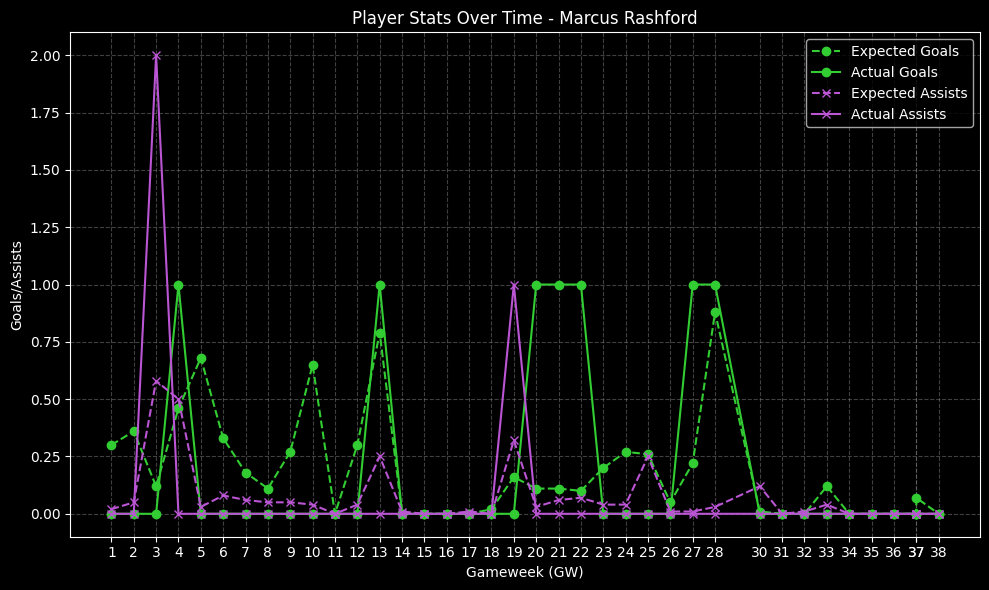

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_player_stats(df, full_name):
    # Filter data for the specific player
    player_data = df[df['name'] == full_name]

    # Set the 'GW' column as the index
    player_data = player_data.set_index('GW')

    # Set dark background theme
    plt.style.use('dark_background')

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Define colors for goals and assists
    goal_color = '#32cd32'  # Lime Green (same color for both expected and actual goals)
    assist_color = '#ba55d3'  # Medium Orchid (same color for both expected and actual assists)

    # Plot expected goals and actual goals with the same color but different line styles
    plt.plot(player_data.index, player_data['expected_goals'], label='Expected Goals', marker='o', linestyle='--', color=goal_color)  # Dotted line for expected goals
    plt.plot(player_data.index, player_data['goals_scored'], label='Actual Goals', marker='o', linestyle='-', color=goal_color)  # Solid line for actual goals

    # Plot expected assists and actual assists with the same color but different line styles
    plt.plot(player_data.index, player_data['expected_assists'], label='Expected Assists', marker='x', linestyle='--', color=assist_color)  # Dotted line for expected assists
    plt.plot(player_data.index, player_data['assists'], label='Actual Assists', marker='x', linestyle='-', color=assist_color)  # Solid line for actual assists

    # Adding labels and title
    plt.xlabel('Gameweek (GW)', color='white')
    plt.ylabel('Goals/Assists', color='white')
    plt.title(f'Player Stats Over Time - {full_name}', color='white')
    plt.legend()

    # Customize ticks and grid
    plt.xticks(player_data.index, color='white')
    plt.yticks(color='white')
    plt.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_player_stats(df1, 'Marcus Rashford')


#  Visuals to Add

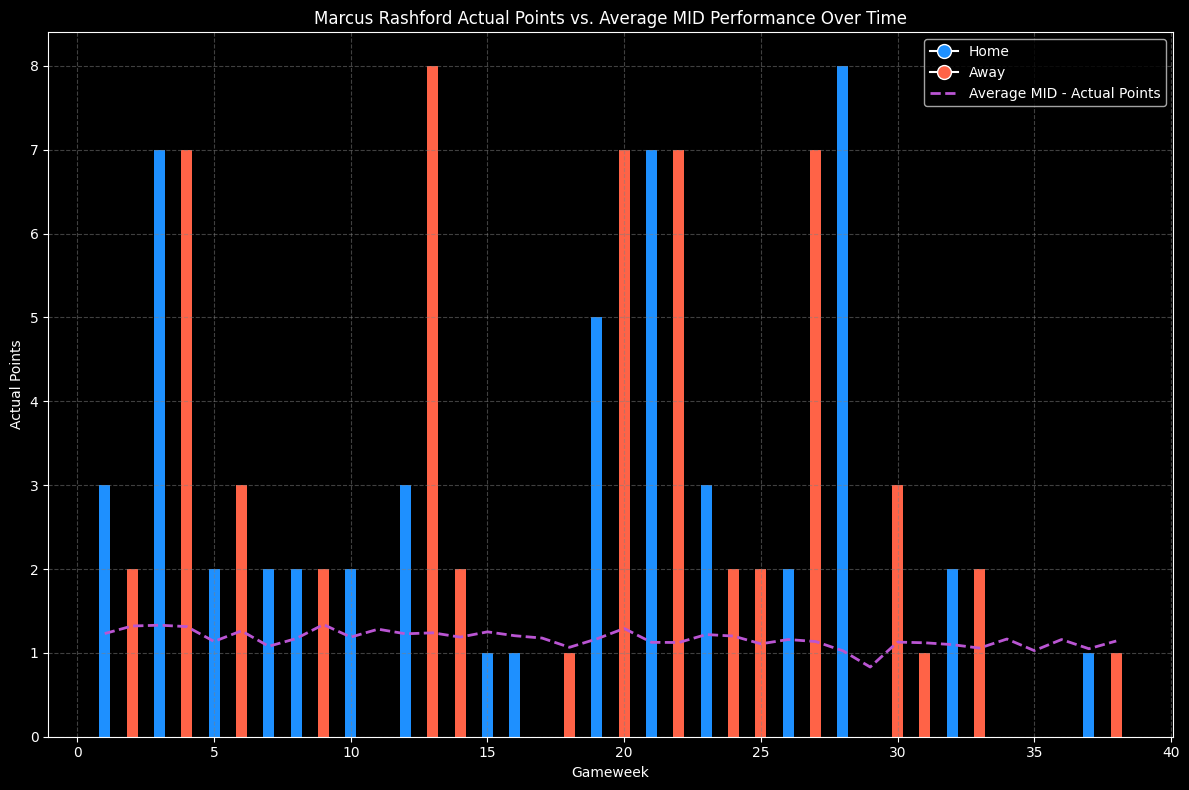

In [28]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

def plot_player_vs_avg_actual_points(df, full_name):
    # Filter the data for the specific player
    player_data = df[df['name'] == full_name]
    
    # Find the player's position
    player_position = player_data['position'].iloc[0]
    
    # Calculate the average actual points for the player's position
    avg_position_data = df[df['position'] == player_position]
    avg_actual_points = avg_position_data.groupby('GW')['total_points'].mean().reset_index()
    
    # Set the dark theme for the plot
    plt.style.use('dark_background')

    # Create a figure to plot the bar chart and lines
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Loop through the gameweeks and conditionally color the bars based on 'was_home'
    for i, row in player_data.iterrows():
        bar_color = '#1e90ff' if row['was_home'] == 1 else '#ff6347'  # Blue for home, Red/Pink for away
        ax.bar(row['GW'], row['total_points'], width=0.4, color=bar_color, label=f'{full_name} - Actual Points' if i == 0 else "")
    
    # Line plot for the average actual points for the position
    ax.plot(avg_actual_points['GW'], avg_actual_points['total_points'], label=f'Average {player_position} - Actual Points', color='#ba55d3', linestyle='--', linewidth=2)

    # Add labels and title
    ax.set_xlabel('Gameweek', color='white')
    ax.set_ylabel('Actual Points', color='white')
    ax.set_title(f'{full_name} Actual Points vs. Average {player_position} Performance Over Time', color='white')

    # Create a custom legend for home/away
    home_away_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#1e90ff', markersize=10, label='Home'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff6347', markersize=10, label='Away')
    ]
    
    # Add the legend to the plot
    ax.legend(handles=home_away_legend + ax.get_legend_handles_labels()[0])

    # Customize ticks and grid
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_player_vs_avg_actual_points(df1, 'Marcus Rashford')


## Ignore

In [30]:
df1.columns



Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [43]:
import plotly.graph_objects as go
from plotly.offline import iplot

def plot_player_vs_avg_actual_points_dynamic(df, full_name):
    # Filter the data for the specific player
    player_data = df[df['name'] == full_name]
    
    # Find the player's position
    player_position = player_data['position'].iloc[0]
    
    # Calculate the average actual points for the player's position
    avg_position_data = df[df['position'] == player_position]
    avg_actual_points = avg_position_data.groupby('GW')['total_points'].mean().reset_index()
    
    # Create the figure using plotly
    fig = go.Figure()

    # Add bars for actual points (with color based on home/away)
    fig.add_trace(go.Bar(
        x=player_data['GW'],
        y=player_data['total_points'],
        marker=dict(color=player_data['was_home'].map({1: '#1e90ff', 0: '#ff6347'})),
        name=f'{full_name} - Actual Points',
        hovertemplate='Gameweek: %{x}<br>Points: %{y}<br>Opponent: %{customdata}<extra></extra>',
        customdata=player_data['opponent_team'],  # Hover data
        showlegend=True
    ))

    # Add line for average actual points
    fig.add_trace(go.Scatter(
        x=avg_actual_points['GW'],
        y=avg_actual_points['total_points'],
        mode='lines',
        name=f'Average {player_position} - Actual Points',
        line=dict(color='#ba55d3', dash='dash', width=2)
    ))

    # Set layout and title
    fig.update_layout(
        title=f'{full_name} Actual Points vs. Average {player_position} Performance Over Time',
        xaxis_title='Gameweek',
        yaxis_title='Actual Points',
        template='plotly_dark',  # Dark theme
        legend_title='Legend',
        hovermode='closest'
    )
    
    # Show the figure using offline mode
    iplot(fig)

# Example usage
plot_player_vs_avg_actual_points_dynamic(df1, 'Marcus Rashford')


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [38]:
pip show nbformat


Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License
        
        - Copyright (c) 2001-2015, IPython Development Team
        - Copyright (c) 2015-, Jupyter Development Team
        
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        1. Redistributions of source code must retain the above copyright notice, this
           list of conditions and the following disclaimer.
        
        2. Redistributions in binary form must reproduce the above copyright notice,
           this list of conditions and the following disclaimer in the documentation
           and/or other materials provided with the distribution.
        
        3. Neither the name of the copyright holder nor